# LLE (Locally Linear Embedding)
- Non-Linear Dimensionality Reduction 기법인 LLE를 수행 해 보자.

- Step 1
  - 모든 점에 대해서 Neighbor를 계산한다.

- Step 2
  - 각 point에 대해 선택된 Neighbor에 의해 자기 자신 point가 잘 표현될 수 있도록 선형 변환을 위한 Weight(W)를 계산한다.

- Step 3
  - Weight를 사용해 변환된 공간에서의 각 point와 주변 point와의 거리의 차가 최소가 되도록 최적화 하여, y 좌표계를 계산한다.

In [1]:
from sklearn.metrics import pairwise_distances
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp
import sklearn as skl
import warnings
from sklearn.metrics import pairwise_distances
from sklearn import datasets
# from sklearn import manifold, datasets
# from sklearn.utils.graph_shortest_path import graph_shortest_path
# import networkx as nx

# LLE Class
- 위의 알고리즘 Step을 모두 지원한다.

In [9]:
class LLE:
    def __init__(self, X, k_n, dim, reg = 1e-03, verbose = False, sparsity = False):
        """
        Input
            X: 변환해야 할 입력 변수, nxd matrix
            k_n: 이웃의 수. number of neighbours
            dim: 원본 데이터의 차원 수. number of coordinates
            reg: 정규화 상수. regularization constant
        Output

        """
        self.X = X
        self.k_n = k_n
        self.dim = dim
        self.reg = reg if self.k_n > self.dim else 0
        self.n = self.X.shape[0]
        self.verbose = verbose
        self.sparsity = sparsity
        
    def __compute_weights(self):
        """
        Compute weights

        X Matrix의 point와 k-neareset neighbor point사이의 distance matrix를 사용하여, 최적화를 통해 W를 구한다. 
        """
        
        dist_matrix = pairwise_distances(self.X)
        # k_n nearest neighbor indices
        knn_matrix = np.argsort(dist_matrix, axis = 1)[:, 1 : self.k_n + 1]
        
        W = [] # Initialize nxn weight matrix
        for i in range(self.n):
            x_i = self.X[i]
            G = [] # Local covariance matrix
            for j in range(self.k_n):
                x_j = self.X[knn_matrix[i][j]]
                G_aux = []
                for k in range(self.k_n):
                    x_k = self.X[knn_matrix[i][k]]
                    gjk = np.dot((x_i - x_j), (x_i - x_k))
                    G_aux.append(gjk)
                G.append(G_aux)
            G = np.array(G)
            G = G + self.reg*np.eye(*G.shape) # Regularization for G
            w = np.linalg.solve(G, np.ones((self.k_n))) # Calculate weights for x_i
            w = w / w.sum() # Normalize weights; sum(w)=1
            
            if self.verbose and i % 30 == 0:
                print('[INFO] Weights calculated for {} observations'.format(i + 1))
                
            # Create an 1xn array that will contain a 0 if x_j is not a 
            # neighbour of x_i, otherwise it will cointain the weight of x_j
            w_all = np.zeros((1, self.n))
            np.put(w_all, knn_matrix[i], w)
            W.append(list(w_all[0]))
            
        self.W_ = np.array(W)
    
    def transform(self):
        """
        Compute embedding
        """
            
        # Step 1 & 2를 동시에 진행한다.
        # k-nearest neighbor를 통해 data point의 거리 matrix D를 구한 후, W를 최적화를 통해 구한다.
        self.__compute_weights() # Compute weights
        
        if self.sparsity:
            # Implementation taken from SLT-CE-1: Locally Linear Embedding; tdiggelm
            # https://github.com/tdiggelm/eth-slt-ce-1/blob/master/slt-ce-1.ipynb
            
            W_s = sp.sparse.lil_matrix(self.W_)
            # Compute matrix M
            M = (sp.sparse.eye(*W_s.shape) - W_s).T * (sp.sparse.eye(*W_s.shape) - W_s)
            M = M.tocsc()
            
            r = skl.utils.check_random_state(3)
            v0 = r.uniform(-1, 1, M.shape[0])
            eigval, eigvec = sp.sparse.linalg.eigsh(M, k=self.dim+1, sigma=0.0, v0 = v0)
            self.Y = eigvec[:, 1:]
        else:
            # Compute matrix M : M = (I-W)^T(I-W) 
            M = (np.eye(*self.W_.shape) - self.W_).T @ (np.eye(*self.W_.shape) - self.W_) 
            eigval, eigvec = np.linalg.eigh(M) # Decompose matrix M
            self.Y = eigvec[:, 1:self.dim +1]
        
        return self.Y

    def plot_neighbors_graph_2d(self, grid = False, size = (15, 10), fig = False):
        if self.X.shape[1] != 2:
            warnings.warn("Data is not 2-dimensional")
            return
        
        dist_matrix = pairwise_distances(self.X)

        # 거리에 따라 k_n개의 이웃만 선택하여 Visualization하도록 한다.
        vecinos = np.argsort(dist_matrix, axis = 1)[:, 1 : self.k_n + 1]
        if not fig:
            plt.style.use('seaborn-whitegrid')
            fig = plt.figure(figsize=size)
        plt.scatter(self.X[:,0], self.X[:,1])
        for i in range(self.n):
            veins = vecinos[i]
            for j in range(len(veins)):
                plt.plot(self.X[[i, veins[j]], 0], self.X[[i, veins[j]], 1], c='gray')
        plt.grid(grid)
        plt.axis(False)
        plt.title('LLE with k = {}'.format(self.k_n))
        if not fig:
            plt.show()
    
    def plot_embedding_2d(self, colors, grid = True, dim_1 = 1, dim_2 = 2, cmap = None, size = (15, 10)):
        if self.dim < 2 and dim_2 <= self.dim and dim_1 <= self.dim:
            warnings.warn("There's not enough coordinates")
            return
        
        plt.style.use('seaborn-whitegrid')
        fig = plt.figure(figsize=size)
        plt.axhline(c = 'black', alpha = 0.2)
        plt.axvline(c = 'black', alpha = 0.2)
        if cmap is None:
            plt.scatter(self.Y[:, dim_1 - 1], self.Y[:, dim_2 - 1], c = colors)
            
        plt.scatter(self.Y[:, dim_1 - 1], self.Y[:, dim_2 - 1], c = colors, cmap=cmap)
        plt.grid(grid)
        plt.title('LLE with k = {}'.format(self.k_n))
        plt.xlabel('Coordinate {}'.format(dim_1))
        plt.ylabel('Coordinate {}'.format(dim_2))
        plt.show()
    
    def plot_embedding_3d(self, colors, grid = True, dim_1 = 1, dim_2 = 2, dim_3 = 3, cmap = None, size = (15, 10)):
        if self.dim < 3 and dim_2 <= self.dim and dim_1 <= self.dim and dim_3 <= self.dim:
            warnings.warn("There's not enough coordinates")
            return
        
        plt.style.use('seaborn-whitegrid')
        fig = plt.figure(figsize=size)
        ax = fig.add_subplot(111, projection="3d")
        if cmap is None:
            ax.scatter(self.Y[:, dim_1 - 1], self.Y[:, dim_2 - 1], self.Y[:, dim_3 - 1], c = colors)
        ax.scatter(self.Y[:, dim_1 - 1], self.Y[:, dim_2 - 1], self.Y[:, dim_3 - 1], c = colors, cmap = cmap)
        plt.grid(grid)
        ax.axis('on')
        plt.title('LLE with k = {}'.format(self.k_n))
        ax.set_xlabel('Coordinate {}'.format(dim_1))
        ax.set_ylabel('Coordinate {}'.format(dim_2))
        ax.set_zlabel('Coordinate {}'.format(dim_3))
        plt.show()
    

# Swiss roll 데이터를 생성한다.
- 맛있게 생긴 Swiss roll data를 sample genearator로 생성한다. (200개 points)

In [3]:
X, y = datasets._samples_generator.make_swiss_roll(200, noise=0.5, random_state=42)
X = X[:, [0, 2]]

# k 값의 변화에 따른 LLE 결과 변화 테스트
- k-Nearest Neighborhood의 k값(이웃 개수) 변화에 따른 LLE결과를 Visualize한다.

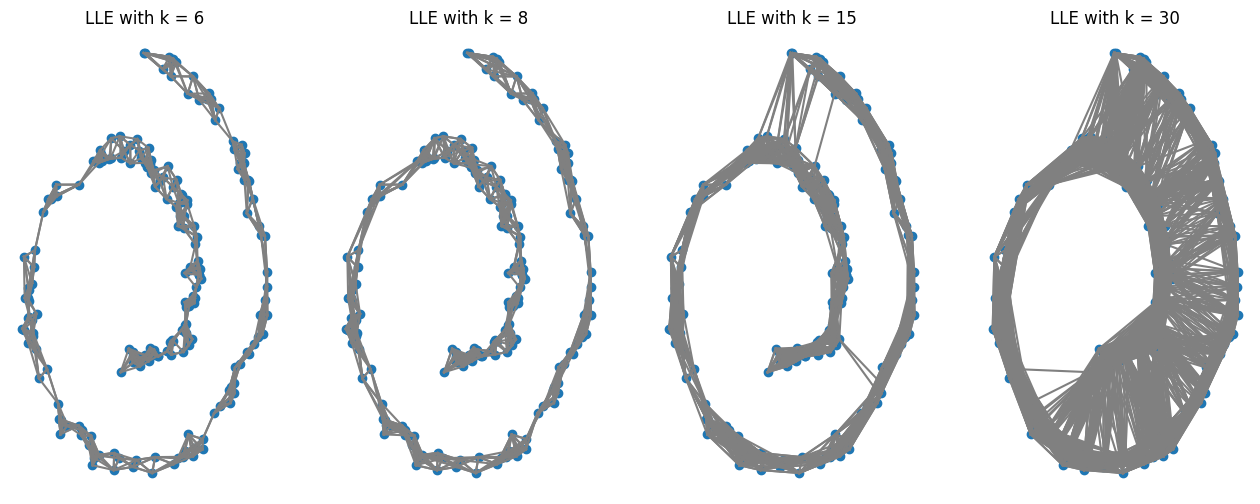

In [4]:
# %%time
fig = plt.figure(figsize=(16, 6))
for ind_plot, k in zip(range(1, 5), [6, 8, 15, 30]):
    plt.subplot(1, 4, ind_plot)
    lle = LLE(X, k, 3, sparsity = True)
    lle.plot_neighbors_graph_2d(fig=True)
    
plt.show()

# X Data 재생성
- Swiss Roll을 다시 2000개 데이터 포인트 생성한다.

In [5]:
X, color = datasets._samples_generator.make_swiss_roll(n_samples=2000, random_state = 2456)


# Visualize Raw Data Points

Text(0.5, 0, 'Z Label')

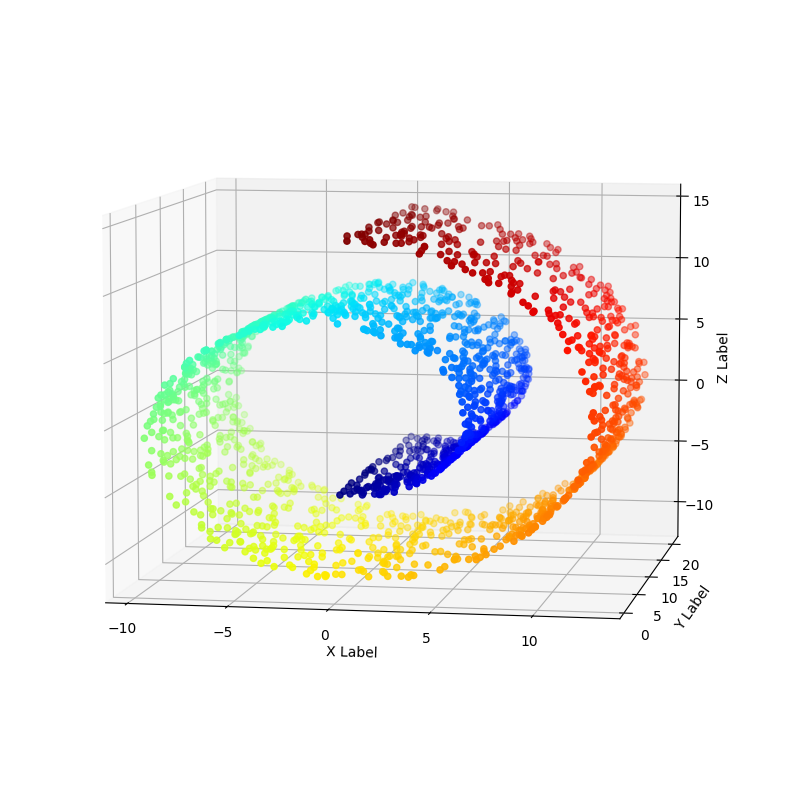

In [6]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(7, -80)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.jet)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# LLE 수행
- LLE를 수행하여 k에 따라 수행 결과를 비교 한다.

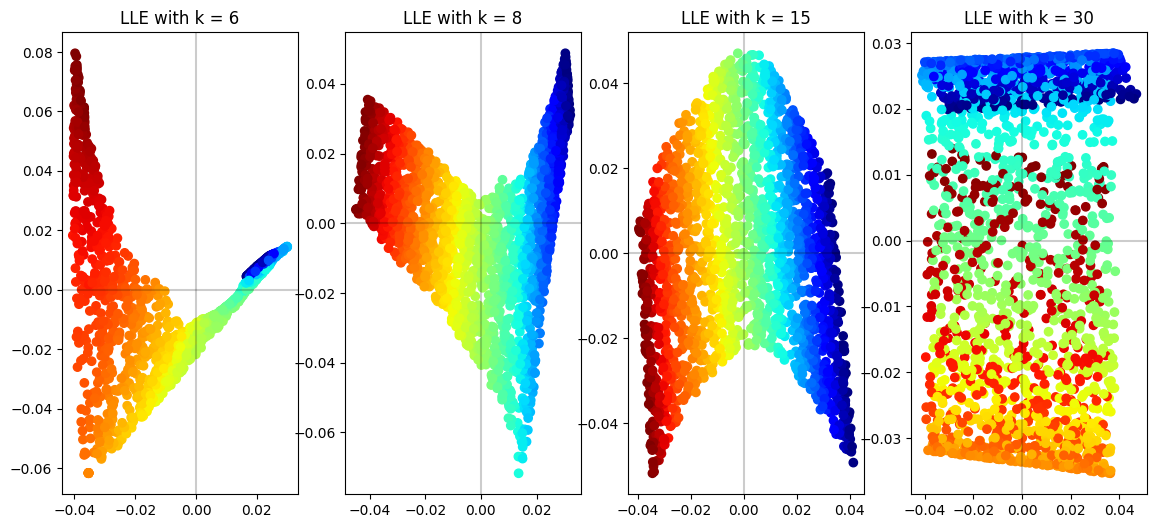

In [10]:
# %%time
fig = plt.figure(figsize=(14, 6))
for ind_plot, k in zip(range(1, 5), [6, 8, 15, 30]):
    plt.subplot(1, 4, ind_plot)
    lle = LLE(X, k, 3, sparsity = True)
    t = lle.transform()
    
    plt.axhline(c = 'black', alpha = 0.2)
    plt.axvline(c = 'black', alpha = 0.2)
            
    plt.scatter(t[:, 0], t[:, 1], c = color, cmap=plt.cm.jet)
    plt.grid(False)
    plt.title('LLE with k = {}'.format(k))
    
plt.show()